In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nengo
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import BasicVecFeed, meg_from_spikes, make_alt_vocab

In [2]:
t_present = 0.3
t_pause = 0.1
dimensions = 32
n_neurons = 25
dt = 0.001
seed = 8

In [3]:
t_pres = int(t_present / dt)
t_paus = int(t_pause / dt)
slc_tm = (t_paus+t_pres)

In [4]:
vocab, fan1, fan1_vecs, fan2, fan2_vecs, foil1, foil1_vecs, foil2, foil2_vecs = make_alt_vocab(5, 5, dimensions, seed, norm=True)

In [5]:
mean_fan1 = np.mean(fan1_vecs, axis=0)
print(mean_fan1.shape)

mean_fan2 = np.mean(fan2_vecs, axis=0)
print(mean_fan2.shape)

(32,)
(32,)


In [6]:
fan_vecs = np.concatenate((fan1_vecs, fan2_vecs))
simi = np.dot(fan_vecs, fan_vecs.T)
np.fill_diagonal(simi, 0.)
intercept = np.ceil(np.max(simi)*100)/100
print(intercept)

0.68


In [7]:
foil_vecs = np.concatenate((foil1_vecs, foil2_vecs))
simi = np.dot(foil_vecs, foil_vecs.T)
np.fill_diagonal(simi, 0.)
foil_intercept = np.ceil(np.max(simi)*100)/100
print(foil_intercept)

0.61


In [8]:
fan_labels = []
for i1, i2 in fan1+fan2:
    fan_labels.append(f"{i1}+{i2}")
print(fan_labels)

['F1_0+F1_1', 'F1_2+F1_3', 'F1_4+F1_5', 'F1_6+F1_7', 'F1_8+F1_9', 'F2_0+F2_1', 'F2_1+F2_2', 'F2_2+F2_3', 'F2_3+F2_4', 'F2_4+F2_0']


In [9]:
foil_labels = []
for i1, i2 in foil1+foil2:
    foil_labels.append(f"{i1}+{i2}")
print(foil_labels)

['F1_0+F1_5', 'F1_1+F1_6', 'F1_2+F1_7', 'F1_3+F1_8', 'F1_4+F1_9', 'F2_0+F2_2', 'F2_0+F2_3', 'F2_1+F2_3', 'F2_1+F2_4', 'F2_2+F2_4']


# Basic associative memory

In [53]:
v_pair = spa.Vocabulary(dimensions)

for v_i, vec in enumerate(fan1_vecs):
    v_pair.add("P1_%s" % v_i, vec)

for v_i, vec in enumerate(fan2_vecs):
    v_pair.add("P2_%s" % v_i, vec)

In [75]:
fan_feed = BasicVecFeed(fan_vecs, fan_vecs, t_present, dimensions, len(fan_vecs), t_pause)

with nengo.Network() as model:
    stim = nengo.Node(fan_feed.feed)
    correct = nengo.Node(fan_feed.get_answer)

    # Note: if the threshold is set too high, it won't respond even close to the MEG
    # because it will then ignore values that would otherwise be considered similar
    # so set it as low as possible to see MEG-like effects
    mem = spa.WTAAssocMem(input_vocab=v_pair, n_neurons=n_neurons, threshold=0.0, function=lambda x: x > 0.)
    
    nengo.Connection(stim, mem.input, synapse=None)
    
    p_rec = nengo.Probe(mem.output, synapse=0.01)
    p_cor = nengo.Probe(correct, synapse=None)
    p_spikes = []

    for am_ens in mem.selection.thresholding.ea_ensembles:
        p_spikes.append(nengo.Probe(am_ens.neurons))

In [76]:
with nengo.Simulator(model) as sim:
    sim.run(len(fan_vecs)*(t_present+t_pause) + t_pause)

Building finished in 0:00:01.                                                                                  
Simulating finished in 0:00:03.                                                                                


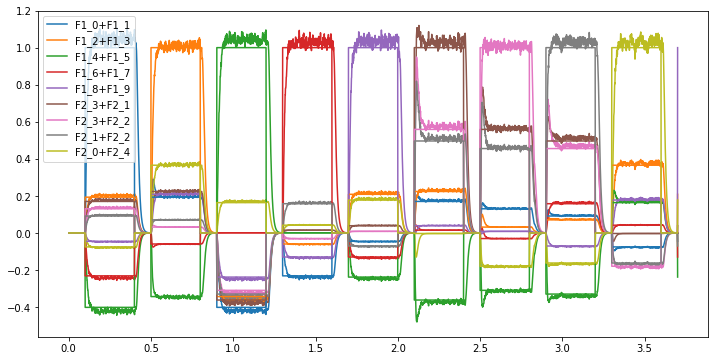

In [77]:
plt.figure(figsize=(12, 6))

plt.plot(sim.trange(), spa.similarity(sim.data[p_rec], fan_vecs))

plt.gca().set_prop_cycle(None)

plt.plot(sim.trange(), spa.similarity(sim.data[p_cor], fan_vecs))

plt.legend(fan_labels)

In [78]:
foil_feed = BasicVecFeed(foil_vecs, foil_vecs, t_present, dimensions, len(foil_vecs), t_pause)

stim.output = foil_feed.feed
correct.output = foil_feed.get_answer

with nengo.Simulator(model) as sim:
    sim.run(len(foil_vecs)*(t_present+t_pause) + t_pause)

Building finished in 0:00:01.                                                                                  
Simulating finished in 0:00:03.                                                                                


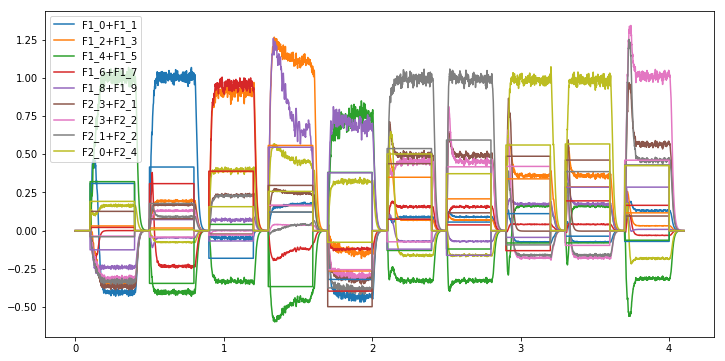

In [79]:
plt.figure(figsize=(12, 6))

plt.plot(sim.trange(), spa.similarity(sim.data[p_rec], fan_vecs))

plt.gca().set_prop_cycle(None)

plt.plot(sim.trange(), spa.similarity(sim.data[p_cor], fan_vecs))

plt.legend(fan_labels)

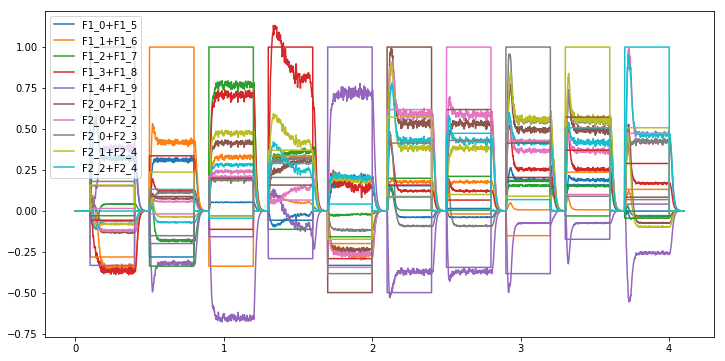

In [80]:
plt.figure(figsize=(12, 6))

plt.plot(sim.trange(), spa.similarity(sim.data[p_rec], foil_vecs))

plt.gca().set_prop_cycle(None)

plt.plot(sim.trange(), spa.similarity(sim.data[p_cor], foil_vecs))

plt.legend(foil_labels)

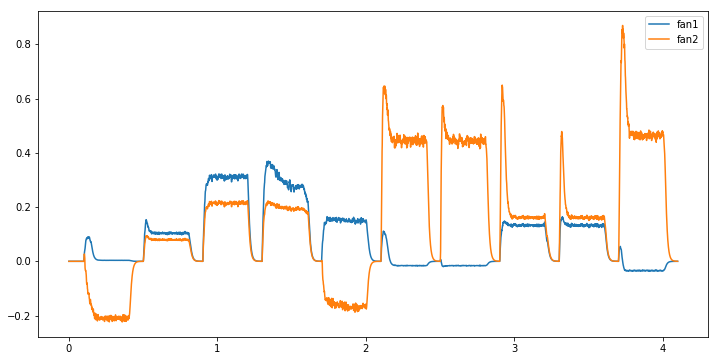

In [81]:
plt.figure(figsize=(12, 6))

plt.plot(sim.trange(), np.dot(sim.data[p_rec], mean_fan1))

plt.plot(sim.trange(), np.dot(sim.data[p_rec], mean_fan2))

plt.legend(["fan1", "fan2"])

# Basic voja memory

In [20]:
from nengo_learn_assoc_mem.learn_assoc import LearningAssocMem

n_neurons = 40
data_feed = BasicVecFeed(fan_vecs, fan_vecs, t_present, dimensions, len(fan_vecs), t_pause)

def is_ans(t, x):
    if np.abs(np.sum(x)) > 0:
        return 1
    else:
        return -1

with nengo.Network() as train_model:
    stim = nengo.Node(data_feed.feed)
    correct = nengo.Node(data_feed.get_answer)
    learn_control = nengo.Node(is_ans, size_in=dimensions)
    
    # Note: setting the intercept doesn't really change much, because there's so much similarity already
    mem = LearningAssocMem(n_neurons, dimensions, voja_rate=1e-5, pes_rate=1e-3, intercepts=np.ones(n_neurons)*0.1, seed=seed)
    
    nengo.Connection(stim, mem.input, synapse=None)
    nengo.Connection(correct, mem.correct, synapse=None)

    nengo.Connection(correct, learn_control, synapse=None)
    nengo.Connection(learn_control, mem.stop_learn)
    
    p_rec = nengo.Probe(mem.output, synapse=0.01)
    p_cor = nengo.Probe(correct, synapse=None)

    train_model.p_enc = nengo.Probe(mem.mem, 'scaled_encoders', sample_every=0.1)
    train_model.p_dec = nengo.Probe(mem.conn_out, 'weights', sample_every=0.1)

In [21]:
with nengo.Simulator(train_model) as train_sim:
    train_sim.run(len(fan_labels)*(t_present+t_pause)*20 + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:26.                                                 


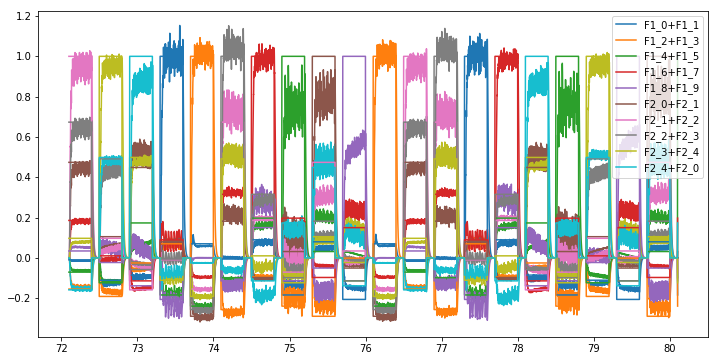

In [22]:
plt.figure(figsize=(12, 6))
win = int(len(fan_labels)*(t_present+t_pause) / dt) * 2

t_win = train_sim.trange()[-win:]

plt.plot(t_win, spa.similarity(train_sim.data[p_rec][-win:], fan_vecs))

plt.gca().set_prop_cycle(None)

plt.plot(t_win, spa.similarity(train_sim.data[p_cor][-win:], fan_vecs))

plt.legend(fan_labels)

In [24]:
for n_i, nrn in enumerate(range(n_neurons)):
    diff = np.sum(train_sim.data[train_model.p_enc][0, nrn, :] - train_sim.data[train_model.p_enc][-1, nrn, :])
    if diff > 0:
        print(n_i, diff)

1 0.09741538705347319
4 0.6732852877310316
6 0.06435898404098553
10 0.09540558698387219
14 0.16642856881863943
17 0.2795049373176382
19 0.29771935363423707
23 0.23471034131401908
27 0.06396157847530692
35 0.0188203832363317


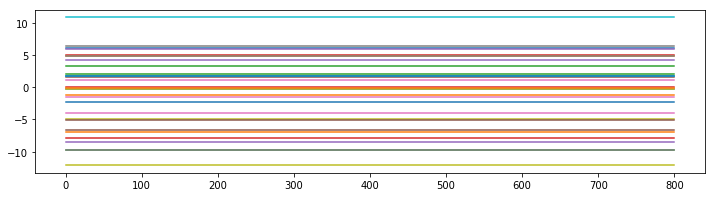

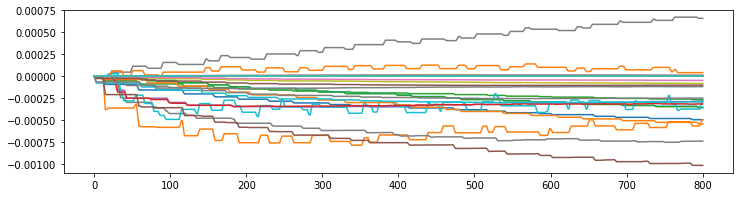

In [13]:
plt.figure(figsize=(12, 3))

plt.plot(train_sim.data[train_model.p_enc][:, 0, :]);

plt.figure(figsize=(12, 3))

plt.plot(train_sim.data[train_model.p_dec][:, 0, :]);

In [17]:
load_from = {}
load_from["enc"] = train_sim.data[train_model.p_enc][-1].copy()
load_from["dec"] = train_sim.data[train_model.p_dec][-1].copy()
load_from["seed"] = seed

data_feed = BasicVecFeed(fan_vecs, fan_vecs, t_present, dimensions, len(fan_vecs), t_pause)

with nengo.Network() as model:
    stim = nengo.Node(data_feed.feed)
    correct = nengo.Node(data_feed.get_answer)

    mem = LearningAssocMem(n_neurons, dimensions, voja_rate=0, pes_rate=0, load_from=load_from, intercepts=np.ones(n_neurons)*0.1)

    nengo.Connection(stim, mem.input, synapse=None)

    p_rec = nengo.Probe(mem.output, synapse=0.01)
    p_cor = nengo.Probe(correct, synapse=None)
    p_spikes = nengo.Probe(mem.mem.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(len(fan_labels)*(t_present+t_pause) + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


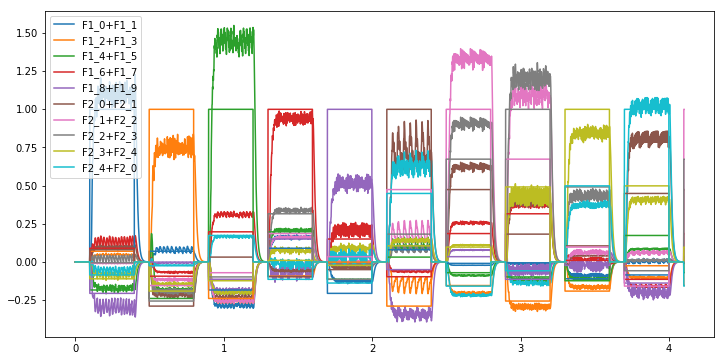

In [18]:
plt.figure(figsize=(12, 6))

plt.plot(sim.trange(), spa.similarity(sim.data[p_rec], fan_vecs))

plt.gca().set_prop_cycle(None)

plt.plot(sim.trange(), spa.similarity(sim.data[p_cor], fan_vecs))

plt.legend(fan_labels)

In [69]:
ens_responses = meg_from_spikes(sim.data[p_spikes])

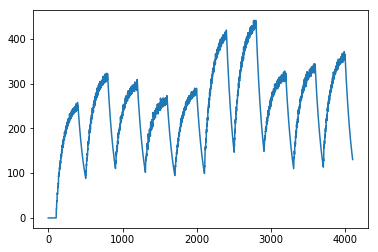

In [70]:
plt.plot(ens_responses)

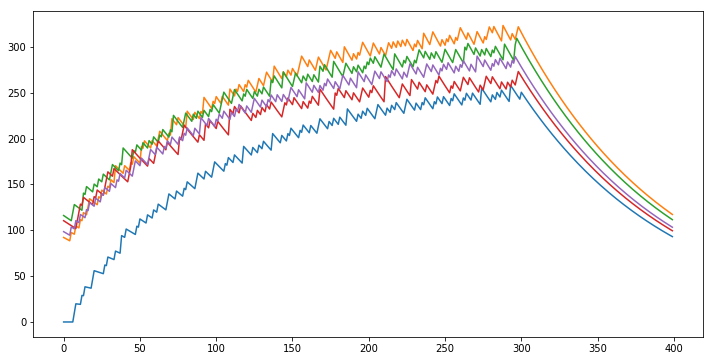

In [71]:
plt.figure(figsize=(12, 6))

t_pres = int(t_present / dt)

fan1_resp = []

for t_p in range(t_paus, len(fan1)*slc_tm, slc_tm):
    fan1_resp.append(ens_responses[t_p:t_p+slc_tm])
    plt.plot(fan1_resp[-1])

fan1_resp = np.array(fan1_resp).T

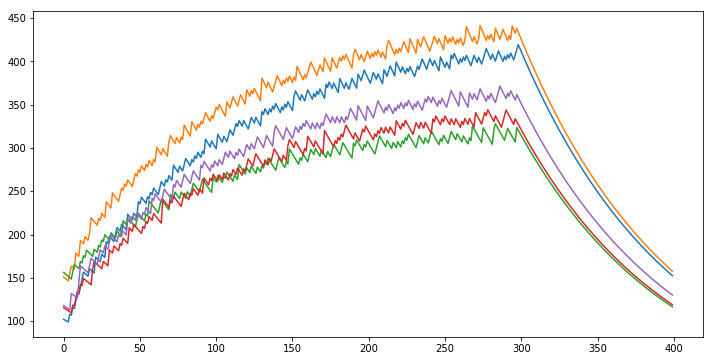

In [72]:
plt.figure(figsize=(12, 6))

t_pres = int(t_present / dt)
fan2_resp = []

for t_p in range(t_paus+len(fan1)*slc_tm, (len(fan1)+len(fan2))*slc_tm, slc_tm):
    fan2_resp.append(ens_responses[t_p:t_p+slc_tm])
    plt.plot(fan2_resp[-1])

fan2_resp = np.array(fan2_resp).T

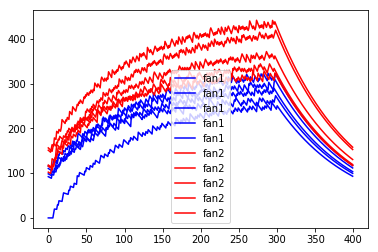

In [73]:
plt.plot(fan1_resp, color='blue', label="fan1")
plt.plot(fan2_resp, color='red', label="fan2")
plt.legend()

/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


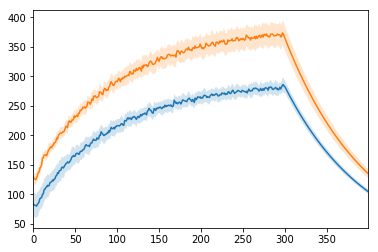

In [74]:
sns.tsplot(fan1_resp.T, color="C0")
sns.tsplot(fan2_resp.T, color="C1")

In [75]:
foil_feed = BasicVecFeed(foil_vecs, foil_vecs, t_present, dimensions, len(foil_vecs), t_pause)

stim.output = foil_feed.feed
correct.output = foil_feed.get_answer

with nengo.Simulator(model) as sim:
    sim.run(len(foil_vecs)*(t_present+t_pause) + t_pause)

Building finished in 0:00:01.                                                                                  
Simulating finished in 0:00:01.                                                                                


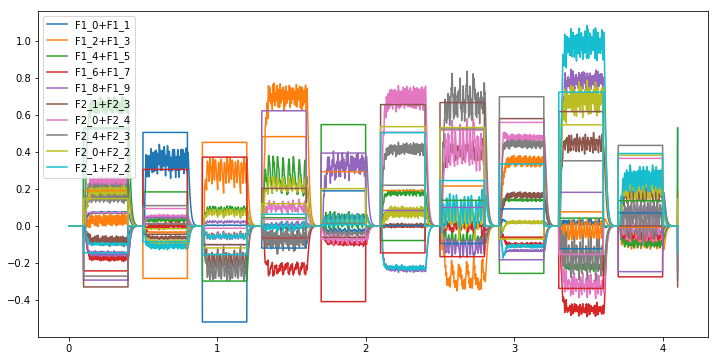

In [77]:
plt.figure(figsize=(12, 6))

plt.plot(sim.trange(), spa.similarity(sim.data[p_rec], fan_vecs))

plt.gca().set_prop_cycle(None)

plt.plot(sim.trange(), spa.similarity(sim.data[p_cor], fan_vecs))

plt.legend(fan_labels)

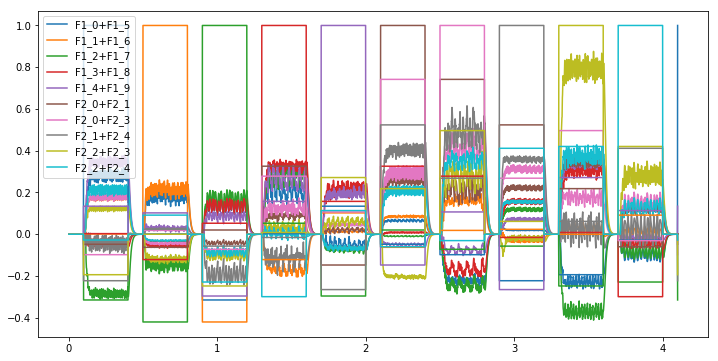

In [78]:
plt.figure(figsize=(12, 6))

plt.plot(sim.trange(), spa.similarity(sim.data[p_rec], foil_vecs))

plt.gca().set_prop_cycle(None)

plt.plot(sim.trange(), spa.similarity(sim.data[p_cor], foil_vecs))

plt.legend(foil_labels)

In [85]:
.shape

(4100,)

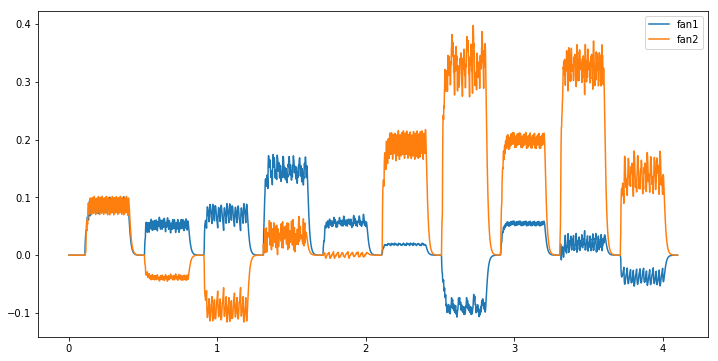

In [86]:
plt.figure(figsize=(12, 6))

plt.plot(sim.trange(), np.dot(sim.data[p_rec], mean_fan1))

plt.plot(sim.trange(), np.dot(sim.data[p_rec], mean_fan2))

plt.legend(["fan1", "fan2"])